# Taxi Tip Prediction using Scikit-Learn and Snap ML

## Introduction

The dataset used in this exercise session is publicly available here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.

In [3]:
# download June 2020 TLC Yellow Taxi Trip records
# Uncomment the next line, if working locally
#!curl https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv 

## Import Libraries

In [4]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml==1.8.2

   ---------------------------------------- 0.0/974.9 kB ? eta -:--:--
   --------------------------------------- 974.9/974.9 kB 15.2 MB/s eta 0:00:00


In [6]:
#Import the needed libraries
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error

import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

## Dataset Analysis

In [34]:
#read the input data
path = 'yellow_tripdata_2019-06.csv'
raw_data = pd.read_csv(path)

print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

#Display first rows in the dataset
raw_data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [35]:
# Explore the dataset
raw_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,3.936004e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06,3.936003e+06
mean,1.640733e+00,1.570112e+00,3.095537e+00,1.058665e+00,1.628665e+02,1.612532e+02,1.291269e+00,1.351268e+01,1.162435e+00,4.951916e-01,2.251814e+00,4.071124e-01,2.986211e-01,1.957001e+01,2.274282e+00
std,5.020742e-01,1.214708e+00,2.351466e+01,7.215995e-01,6.636449e+01,7.048365e+01,4.800985e-01,1.257028e+01,1.275248e+00,5.969404e-02,2.858797e+00,1.818862e+00,2.753095e-02,1.541216e+01,7.285723e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.050000e+02,-2.650000e+01,-5.000000e-01,-8.888000e+01,-1.900000e+01,-3.000000e-01,-3.058000e+02,-2.500000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.950000e+00,0.000000e+00,3.000000e-01,1.480000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,3.160000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.500000e+01,2.500000e+00,5.000000e-01,2.960000e+00,0.000000e+00,3.000000e-01,2.100000e+01,2.500000e+00
max,4.000000e+00,9.000000e+00,4.597722e+04,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,3.004000e+03,1.850000e+01,3.080000e+01,3.569000e+02,8.230000e+02,3.000000e-01,3.007300e+03,2.750000e+00


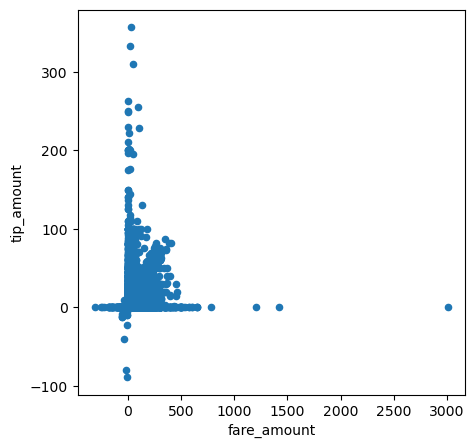

In [36]:
#Explore range of tip_amount

fig, ax = plt.subplots(figsize=(5,5))

raw_data[['tip_amount', 'fare_amount']].plot(kind='scatter', x='fare_amount', y='tip_amount', ax=ax)

plt.show()

Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable. The objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. Let's first clean the dataset and retrieve basic statistics about the target variable.

There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


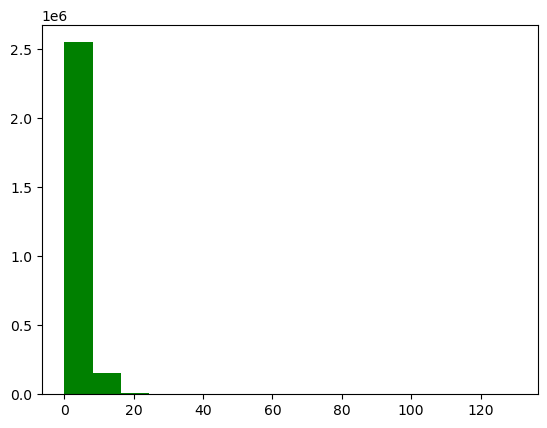

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the trips have a tip amount less or equal than  5.95


In [37]:
#some trips report 0 tip. It is assumed that these tips were paid in cash.
# for this study, we drop all these rows
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

#we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200))]

#we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

#release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

#print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16, histtype="bar", facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

In [38]:
#display first rows in a dataset
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.


## Dataset Preprocessing

In [39]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2712719 entries, 4 to 3936000
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           float64
 8   DOLocationID           float64
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  congestion_surcharge   float64
dtypes: float64(13), int64(1), object(3)
memory usage: 372.5+ MB


In [40]:
#Convert tpep_pickup_datetime and tpep_dropoff_datetime to datetime objects
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])

#Extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

#Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday)
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

#Calculate trip time in seconds
clean_data['trip_time'] = (clean_data['tpep_pickup_datetime'] - clean_data['tpep_dropoff_datetime']).dt.total_seconds()

#Ideally use the full dataset for this exercise
#However if memory runs out, reduce the dataset
#For instance, we use only the first 200,000 samples
first_n_rows = 200000
clean_data = clean_data.head(first_n_rows)

In [41]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

#Some features are categorical, we need to encode them
#to encode, we use one-hot encoding from the pandas package
get_dummy_col = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'pickup_hour', 'dropoff_hour', 'pickup_day', 'dropoff_day']
proc_data = pd.get_dummies(clean_data, columns=get_dummy_col)

#Release memory occupied by clean_data as we do not need it anymore
#We are dealing with large data set thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

4217

In [ ]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

#drop the target variable from the feature matrix
proc_data = proc_data.drop(columns=['tip_amount'])

In [45]:

#get the features matrix used for training
X = proc_data.values

#normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

#print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 517) y.shape= (200000, 1)


## Dataset Train/Test Split
Now that the dataset is ready for building the classification models, need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (140000, 517) Y_train.shape= (140000, 1)
X_test.shape= (60000, 517) Y_test.shape= (60000, 1)


## Build a Decision Tree Regressor model with sklearn

In [48]:
#import library 
from sklearn.tree import DecisionTreeRegressor

#for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

#train a Decision Tree Regressor
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  4.64049


## Build a Decision Tree Regressor model with Snap ML

In [49]:
#import library
from snapml import DecisionTreeRegressor
# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

#Train a Decision Tree Regressor
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  1.10781


## Evaluate the SKLearn and Snap ML Decision Tree Regressor

In [50]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

#run inteference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

#evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 4.19x 
[Scikit-Learn] MSE score : 1.636
[Snap ML] MSE score : 1.654


As shown above both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine faster than Scikit-Learn. This is one of the advantages of using Snap ML: acceleration of training of classical machine learning models, such as linear and tree-based models. For more Snap ML examples, please visit https://github.com/IBM/snapml-examples. Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.

## Practice

Create a SnapML Decision Tree Regressor with `max_dept` set to `12`, `random_state` set to `45`, and `n_jobs` set to `4`

In [51]:
snapml_dt_new = DecisionTreeRegressor(max_depth=12, random_state=45, n_jobs=4)
snapml_dt_new.fit(X_train, y_train)
snapml_pred_new = snapml_dt_new.predict(X_test)
snapml_mse_new = mean_squared_error(y_test, snapml_pred_new)
print("MSE: ", snapml_mse_new)

MSE:  1.8681510922659188


We learned that increasing the `max_depth` parameter to `12` increases the MSE